In [39]:
import os
import dagshub
# os.chdir('..')
print(os.getcwd())
dagshub.init(repo_owner='SalazarV4', repo_name='oil-optimization', mlflow=True)

c:\Users\User\Desktop\DS\Projects\oil-optimization


Initialized MLflow to track repo "SalazarV4/oil-optimization"

Repository SalazarV4/oil-optimization initialized!

## Sklearn

In [3]:
from sklearn.metrics import get_scorer_names

get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_max_error',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 're

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, cross_validate
import mlflow


### Preparing data

In [62]:
df = pd.read_csv('data/processed/features.csv', parse_dates=['period']).drop('year_month',axis=1).set_index('period')
df['cpi_energy'] = df['cpi_energy'].interpolate()
df['oil_production'] = df['oil_production'].interpolate()

X,y = df.drop('wti_price',axis=1), df['wti_price']

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=0,
    test_size=100
)

all_splits = list(ts_cv.split(X,y))

train_idx, test_idx = all_splits[0]
X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [50]:
all_splits[0]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 array([ 68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
        107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
        159, 160, 161, 162, 163, 164, 165, 166, 167]))

### Training
* RandomForest
* XGBoost
* ARIMA/SARIMAX
* GradientBoostingMachine
* Prophet

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb

In [103]:
sklearn_models = {
    "random_forest": RandomForestRegressor(random_state=42),
    "gradient_boosting": GradientBoostingRegressor(random_state=42),
    "xgboost": xgb.XGBRegressor(random_state=42)
}
for model_name, model in sklearn_models.items():

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    mape = mean_absolute_percentage_error(y_test,y_pred)
    rmse = root_mean_squared_error(y_test,y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    metrics = {'test_mape':mape,
                'test_rmse':rmse,
                'test_mae':mae}
    scoring = [
        'neg_mean_absolute_percentage_error',
        'neg_root_mean_squared_error',
        'neg_mean_absolute_error'
        ]

    results = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring=scoring
        )
    
    with mlflow.start_run(run_name=f"{model_name}_run"):
        
        mlflow.log_metrics(metrics)

        for key, result in results.items():
            sorted_importances_idx = result.importances_mean.argsort()
            importances = pd.DataFrame(
                result.importances[sorted_importances_idx].T,
                columns=X.columns[sorted_importances_idx],
            )
            ax = importances.plot.box(vert=False, whis=10)
            ax.set_title("Permutation Importances (test set)")
            ax.axvline(x=0, color="k", linestyle="--")
            ax.set_xlabel(f"Decrease in {key}")
            ax.figure.tight_layout()
            plt.close(ax.figure)
            mlflow.log_figure(ax.figure,artifact_file=f'{key}.png')


    cv_scores = cross_validate(
        model, X, y, cv=ts_cv, scoring=scoring)
    
    metrics = {
        "mean_test_mape": -cv_scores['test_neg_mean_absolute_percentage_error'].mean().round(3).item(),
        "std_test_mape": cv_scores['test_neg_mean_absolute_percentage_error'].std().round(3).item(),
        "mean_test_rmse": -cv_scores['test_neg_root_mean_squared_error'].mean().round(3).item(),
        "std_test_rmse": cv_scores['test_neg_root_mean_squared_error'].std().round(3).item(),
        "mean_test_mae": -cv_scores['test_neg_mean_absolute_error'].mean().round(3).item(),
        "std_test_mae": cv_scores['test_neg_mean_absolute_error'].std().round(3).item()
        }    

    with mlflow.start_run(run_name=f'{model_name}_cv'):
        mlflow.log_metrics(metrics=metrics)

🏃 View run random_forest_run at: https://dagshub.com/SalazarV4/oil-optimization.mlflow/#/experiments/0/runs/444d8a2747c5472a9239b1ceec30e5ac
🧪 View experiment at: https://dagshub.com/SalazarV4/oil-optimization.mlflow/#/experiments/0
🏃 View run random_forest_cv at: https://dagshub.com/SalazarV4/oil-optimization.mlflow/#/experiments/0/runs/807777806c214a4596f5febb34abf37a
🧪 View experiment at: https://dagshub.com/SalazarV4/oil-optimization.mlflow/#/experiments/0
🏃 View run gradient_boosting_run at: https://dagshub.com/SalazarV4/oil-optimization.mlflow/#/experiments/0/runs/358159111ae9464ebb8733308f9fb69f
🧪 View experiment at: https://dagshub.com/SalazarV4/oil-optimization.mlflow/#/experiments/0
🏃 View run gradient_boosting_cv at: https://dagshub.com/SalazarV4/oil-optimization.mlflow/#/experiments/0/runs/44690e3aecaf416bb3993ae089e897b6
🧪 View experiment at: https://dagshub.com/SalazarV4/oil-optimization.mlflow/#/experiments/0
🏃 View run xgboost_run at: https://dagshub.com/SalazarV4/oil-o

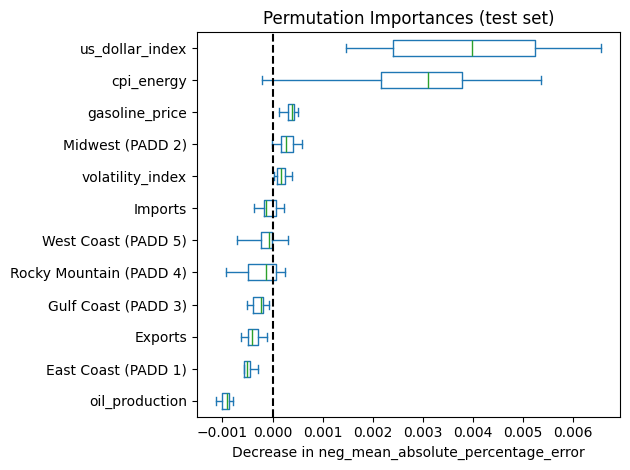

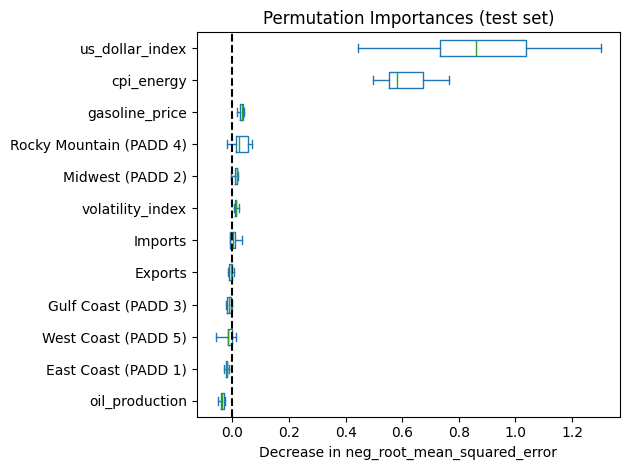

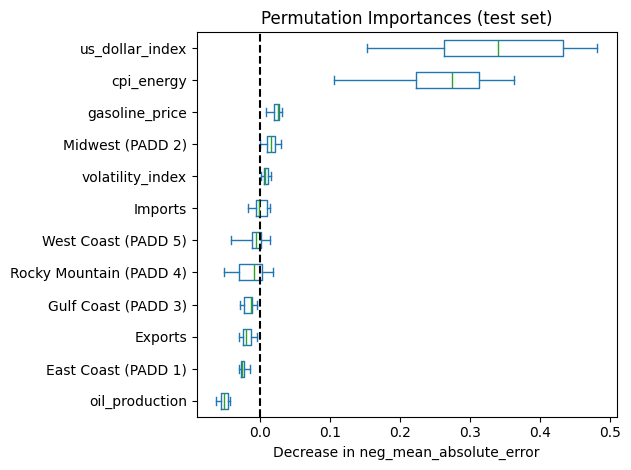

In [ ]:
results = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring=scoring
)
for key, result in results.items():
    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances (test set)")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel(f"Decrease in {key}")
    ax.figure.tight_layout()

{'test_mape': 0.10530362752633739, 'test_rmse': 6.244484605302506, 'test_mae': 5.5119914}


C:\Users\User\AppData\Local\Temp\ipykernel_3772\1243454372.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


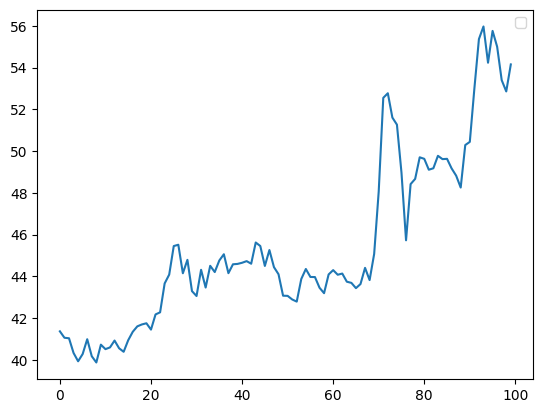

{'test_mape': 0.10012727409740257, 'test_rmse': 6.240132338150238, 'test_mae': 5.296908897166013}


C:\Users\User\AppData\Local\Temp\ipykernel_3772\1243454372.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


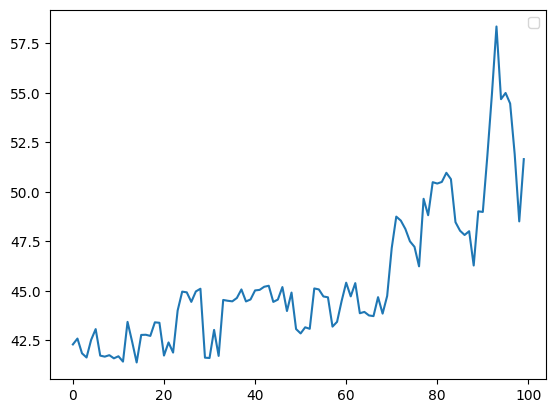

{'test_mape': 0.09866366473292439, 'test_rmse': 6.334105200070904, 'test_mae': 5.214808001403809}


C:\Users\User\AppData\Local\Temp\ipykernel_3772\1243454372.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


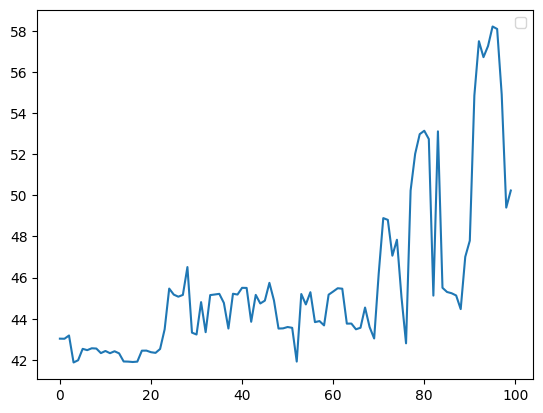

In [65]:
sklearn_models = {
    "random_forest": RandomForestRegressor(random_state=42),
    "gradient_boosting": GradientBoostingRegressor(random_state=42),
    "xgboost": xgb.XGBRegressor(random_state=42)
}
for model_name, model in sklearn_models.items():

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    mape = mean_absolute_percentage_error(y_test,y_pred)
    rmse = root_mean_squared_error(y_test,y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    metrics = {'test_mape':mape,
                'test_rmse':rmse,
                'test_mae':mae}
    
    print(metrics)
    plt.figure()
    plt.plot(y_pred)
    plt.legend()
    plt.show()

In [60]:
pd.Series(y_test).index

DatetimeIndex(['2023-03-03', '2023-03-10', '2023-03-17', '2023-03-24',
               '2023-03-31', '2023-04-07', '2023-04-14', '2023-04-21',
               '2023-04-28', '2023-05-05',
               ...
               '2025-09-12', '2025-09-19', '2025-09-26', '2025-10-03',
               '2025-10-10', '2025-10-17', '2025-10-24', '2025-10-31',
               '2025-11-07', '2025-11-14'],
              dtype='datetime64[ns]', length=142, freq=None)

In [55]:
y_pred.mean()

np.float64(79.31143972907267)

## SKtime

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import RecursiveTabularRegressionForecaster
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

In [48]:
df = pd.read_csv('data/processed/features.csv', parse_dates=['period']).drop('year_month',axis=1).set_index('period')
df['cpi_energy'] = df['cpi_energy'].interpolate()
df['oil_production'] = df['oil_production'].interpolate()

X,y = df.drop('wti_price',axis=1), df['wti_price']

In [49]:
y_train, y_test = temporal_train_test_split(y)

0.4525293076791142


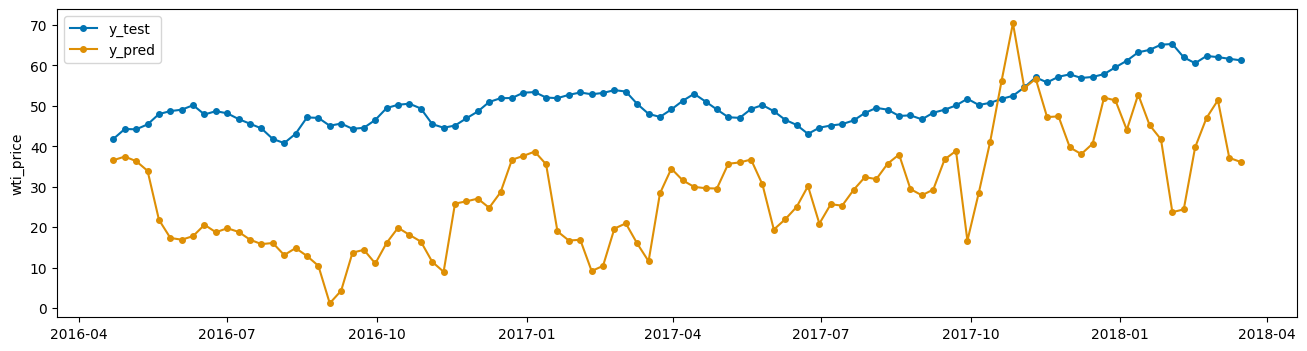

In [81]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
estimator = LinearRegression()

forecaster = RecursiveTabularRegressionForecaster(estimator)
forecaster.fit(y=y_train, X=X_train)
y_pred = forecaster.predict(fh=fh, X=X_test)
print(mean_absolute_percentage_error(y_test,y_pred))
plot_series(y_test,y_pred, labels=['y_test','y_pred'])
plt.show()